---
Replication project for the class of OSE Scientific Computing for Economists | Winter Semester 2021-2022 | Bonn University
[Jessica Cremonese](https://github.com/disj3ssica), [Muhammad-Danial Syed](https://github.com/CasualDan), [Xue Wang](https://github.com/kokomob) <br>

---


# Constrained optimization of the synthetic control method with application to the Economic Costs of Organised Crime (Pinotti, 2015)
###### Jessica Cremonese, Muhammad-Danial Syed, Xue Wang

This notebook contains our replication project of [The Economic Costs of Organised Crime: Evidence from Southern Italy](https://onlinelibrary.wiley.com/doi/abs/10.1111/ecoj.12235) (Pinotti, 2015) with reference to a response paper [Estimating the economic costs of organized crime by synthetic control methods](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.2572) (Becker and Klößner, 2017).

### Viewing the notebook
We recommend [nbviewer](https://nbviewer.org/github/OpenSourceEconomics/ose-scientific-computing-course-jdx-mafia-1/blob/master/Replication%20notebook.ipynb) as it provides a clear and seamless way to experience this notebook including its interactive graphs. Alternatively, the entire GitHub repository dedicated to the project can be downloaded and this notebook can be replicated locally via Jupyter Notebooks.

The approximate runtime is ~55 minutes on a dual-core processor. This may vary due to the use of parallelization to speed up computations where possible. Seeds are used to ensure full replicability of results but minor differences may arise in the exact precision of numerical computations depending on the operating systems. In any case, the conclusions drawn from these computations will still hold.

The following packages are used and their installation will be needed for replication purposes.
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [statsmodels](https://www.statsmodels.org/stable/index.html)
- [Plotly](https://plotly.com/)
- [CVXPY](https://www.cvxpy.org/)
- [SciPy](https://scipy.org/)
- [Matplotlib](https://matplotlib.org/)
- [seaborn](https://seaborn.pydata.org)
- [joblib](https://joblib.readthedocs.io/en/latest/)
- [CPLEX](https://www.ibm.com/docs/en/icos/20.1.0?topic=cplex-setting-up-python-api)
- [qpsolvers](https://pypi.org/project/qpsolvers/)
- [CVXOPT](https://cvxopt.org/install/)
- [SCS](https://www.cvxgrp.org/scs/install/python.html#python-install)
- [osqp](https://osqp.org/docs/get_started/python.html)
- [ecos](https://github.com/embotech/ecos-python)

### Source material
The full dataset for Pinotti (2015) has been made available by the author under the "Supporting Information" section at the following [link](https://onlinelibrary.wiley.com/doi/abs/10.1111/ecoj.12235). <br>
Becker and Klößner's (2017) response replication files can be found [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.2572), also under "Supporting Information".

---
# Table of contents

1. [Introduction](#1)
2. [The Economic Costs of Organised Crime, Pinotti (2015)](#2) <br>
    2.1. [Background](#3) <br>
    2.2. [Empirical Methodology](#4) <br>
      2.2.1. [Assumptions and Identification Strategy](#5) <br>
      2.2.2. [The Synthetic Control Method](#6) <br>
      2.2.3. [Variables](#7) <br>
3. [Application of Synthetic Control Method](#8) <br>
    3.1. [Optimization Objective: A Simplified Problem](#9) <br>
    3.2. [Optimization with addition of predictor importance](#10) <br>
      3.2.1. [The choice of $V$ matters](#11) <br>
      3.2.2. [Approach 1: Iterating over a subset of $\mathcal{V}$](#12) <br>
      3.2.3. [Approach 2: Nested Optimization](#13) <br>
    3.3. [Feasibility of the Unrestricted Outer Optimum and the Computational Challenges of SCM](#14) <br>
4. [Robustness of our SCM Implementation](#15) <br>
    4.1. [Application to alternative empirical cases](#16) <br>
      4.1.1. [The Economic Costs of Conflict: A Case Study of the Basque Country (Abadie and Gardeazabal, 2003)](#17) <br>
      4.1.2. [Comparative Politics and the Synthetic Control Method (Abadie, Diamond and Hainmueller, 2015)](#18) <br>
    4.2. [Numerical Instability in Implementation: Sensitivity to Random Reordering of Donors](#19) <br>
5. [Synthetic Control Performance Analysis](#20) <br>
6. [Robustness Checks](#21) <br>
    6.1. [Sensitivity Analysis](#22) <br>
    6.2. [Placebo Testing](#23) <br>
6. [Conclusions](#24) <br>
7. [References](#25) <br>

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import cvxpy as cp
import numpy as np
import pandas as pd
import warnings
import numpy.linalg as LA
import statsmodels.api as sm
import plotly.graph_objs as go
from qpsolvers import solve_qp
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from joblib import Parallel, delayed
import statsmodels.formula.api as smf
from scipy.optimize import differential_evolution, NonlinearConstraint, Bounds

plt.rcParams['figure.figsize'] = [6, 4.0]

In [2]:
dtafile = './dataset/Pinotti-replication/dataset.dta'
data = pd.read_stata(dtafile)

In [3]:
from auxiliary.section2_graphs import *
from auxiliary.section3_SCM import *
from auxiliary.section4_robustness import *
from auxiliary.section5_analysis import *
from auxiliary.section6_inference import *

---
# 1. Introduction <a name="1"></a>

The issue of organized crime represents a source of potentially adverse socio-economic repercussions across a plethora of communities worldwide, in part due to its prevalence in some form or the other in almost every country. Such criminal groups are characterized by their near-monopolistic use of predation and violence in the provision of illegal goods and services, with activities including protection, bribery, large-scale drugs trafficking, money laundering, and extortion. They can range from highly sophisticated and well-coordinated criminal syndicates, such as the Italian mafias, the Yakuza in Japan, or the Triads in Hong Kong, to the more localized youth street gangs of Los Angeles and Sao Paulo (Kumar and Skaperdas, 2008:1). But regardless of scale and sophistication, these groups present a major challenge to economic development. In fact, in 1994 the UN was even moved to issue the Naples Declaration which officially recognized organized crime's “corrupting influence on fundamental social, economic and political institutions”. 

The extent of this “corrupting influence" motivates the empirical application in our project, which follows the Pinotti (2015) investigation into the economic costs of organized crime by the infamous Italian mafia. The author exploits the heterogeneous presence of mafia across regions in Italy and the fact that some regions were 'treated' by mafia presence only after a certain time period. In particular, a peculiar combination of external shocks in the 1970s meant that these regions were subject to a sharp and permanent rise in mafia activity whilst a core group of comparable control regions remained virtually unaffected. This strategy draws upon the **Synthetic Control Method** (SCM) to construct a counter-factual scenario for the affected regions from a donor pool of control units in order to examine economic performance before and after the increase in organized crime. Ultimately, Pinotti attributes a staggering 16% reduction in average GDP per capita to the presence of organized crime in Italy.

By replicating Pinotti's paper, we recreate its main results showing the effect of organized crime on GDP and we gain insight into the complexities of the SCM. Our project begins with an overview of the topic of organized crime followed by an analysis of the paper featuring descriptive statistics, graphs, and a battery of robustness checks. We use this empirical context to motivate an implementation of the SCM, with emphasis on gradually building up the several optimization steps. This allows us to showcase the flaws of our earlier SCM optimization functions and gain some economic intuition in the process. Our implementations draw on the variety of algorithms available in Python's rich scientific libraries which are used for our intermediate computations. A final point of departure is the examination of a conflicting result by Becker and Klößner's (2017) response paper to Pinotti's (2015). We attempt to reconcile their different findings by investigating some unexpected developments in recent literature on the computational challenges of the SCM. 

---
# 2. *The Economic Costs of Organised Crime*, Pinotti (2015) <a name="2"></a>


## 2.1. Background <a name="3"></a>

The case of the Italian mafia has gained prominence among academic inquiries focusing on the costs of organized crime for the very reason of its powerful and influential criminal enterprise, its traditionally aggressive use of their monopoly on violence, and its long-standing existence in Italy. 

From a historical context, it was born in post-war Sicily, where small congregations held together by *omertà* (a code of silence and behavior which entails the deflection of authorities’ attention from the mafias’ activities by both the members of the clans and the general population) and honor codes started forming. Leonardo Sciascia aptly described it, saying that “The most essential and complete definition one could give of mafia, [...] is the following: a delinquent association, with the aim of illicit enrichment for its associates, which imposes itself as a parasitic intermediary, and imposes itself with violence, between property and work, between production and consumption, between State and citizen” (Scarpino, 1994). Since then, these criminal organizations have engaged in a variety of activities, including extortion, bribery, arson, gambling, trafficking of weapons, narcotics and humans, electoral fraud, usury, kidnapping, counterfeiting, and money laundering. Their endeavours affect all facets of economic activity with an array of negative effects ranging from increased risks and costs of investment to insurance costs against property damage and arson, and payment of *pizzo* (an extortionary transfer of money) to the clans in order to stay in business (Daniele and Marani, 2011; Basile, 2001; Marini and Turato, 2002). Mafias operate in the legal economy as well, however their lawful economic activity can be described as unproductive and destructive entrepreneurship, since they actively misplace and destroy human capital, trust and wealth in order to carry out their activities (Champeyrache, 2018).

To quantify these damaging effects and address the issue of causality, we can rely on an empirical strategy that exploits mafias' heterogeneous presence across regions in Italy. More specifically, although regions such as Campania, Sicily, and Calabria have all been traditional strongholds of mafia operation and are the birthplaces of a number of distinct criminal organizations, other regions in Italy have also suffered overtime by geographical and political proximity. Such regions have gradually become infected by the territorial expansion of ruling clans and the subsequent distortion of regional socio-economic dynamics wrought by exposure to new mafia activity. Two notable examples of this are the regions of Apulia and Basilicata. Once among the fastest growing regions of Italy, these two regions are now lagging behind the rest of the country along with the other historically mafia-plagued regions.

Since Apulia and Basilicata formerly enjoyed such a favorable economic outlook, with levels of criminal activity and economic growth similar to those of other Southern regions unaffected by mafia activity, what changed exactly in the 1970s to facilitate the exposure to organized crime? Pinotti (2015) decomposes this shift into two pivotal factors.
First, the closure of the port of Tangier in 1960 led to a shift in the trade routes of tobacco smugglers, which suddenly involved the Adriatic regions, including the south-eastern Italian coasts of Apulia. This change would represent a decisive factor for mafia involvement a decade later, when tobacco smuggling became the most profitable venture for criminal business in Italy and mafia began looking towards Apulia for new bases to engage in this activity. Nowadays, tobacco smuggling has lost its podium position to large-scale narcotrafficking which follows the same routes.
Second, a strong earthquake hit Basilicata in 1980, affecting the entire region as well as the neighboring regions of Campania and Apulia. Following the natural disaster, government relief and public investment flooded the regions, which in turn the mafia appropriated extensively through embezzlement, intimidation, and corruption of local authorities.

Besides these pivotal events, another measure aided the propagation of criminal networks and influence in the previously unaffected regions: *confino*. The initial intent of this provision was to break up links between mafiosi through the physical separation of the clans' upper echelons by confining them to far away regions, however, not only did the measure fail, but, in the end, it unintentionally aided the transplantation of these organizations into new territories.

These events provide some context into studying the decline in the development of Apulia and Basilicata following the 1970s. To get a better sense of the evolution of mafia activity in these regions during this time period, we can analyze the number of cases ex Art. 416-bis reported by the police to the judicial authority. Introduced after some high profile executions, Art. 416-bis encompasses the true nature of mafia organizations: to qualify as a mafia-type criminal organization there has to be the use of violence, intimidation and the imposition of omertà in order to carry out legal and illegal activity or influence electoral outcomes. This makes Art. 416-bis a powerful one to prosecute mafia, nevertheless its implementation is far from being an easy feat, thus making it an imperfect tool to measure mafia activity for a number of reasons. Mainly, a case against an organization built on Art. 416-bis will take place over a long time and in a specific municipality, regardless of the interregional nature of mafias, and this may distort the measurement of mafia presence when drawing upon crime reporting statistics.

In Figure 1, we show the association between the number of these cases per 100,000 inhabitants and economic performance, measured by GDP per capita, averaged over 1983 to 2007.

#### Figure 1: Mafia-type Criminal Organizations and GDP Per Capita Across Italian Regions, Average Over the Period 1983–2007

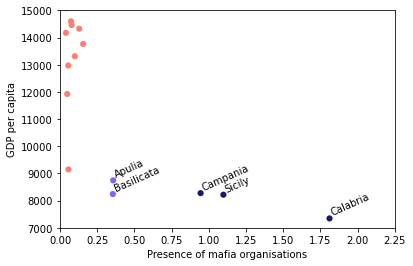

In [4]:
df2 = plot_prep("df2")
fig1_mafia_presence_avg(df2)

The disparity between Italian regions with and without strong mafia presence becomes quickly apparent. In particular, notice that the data appears to be distributed into three groups. The first group is composed of the three regions where mafia-type criminal organizations originated in Italy, namely Sicily, Campania and Calabria. These are among the worst performers in terms of GDP per capita and the most plagued by mafia in both intensity and duration. The second group is formed by Apulia and Basilicata, two regions that have low economic performance but a relatively lower level of mafia compared to the historically mafia-plagued group. The last group is made up of the remaining regions, all of them marked by a relatively low presence of criminal organizations and varying levels of GDP per capita, with its minimal GDP per capita exceeding even the maximum of the previous two groups.

The second group, Apulia and Basilicata, was 'treated' with mafia presence beginning only in the 1970s as a result of events largely independent of their characteristics, and subsequently also witnessed a decline in their economic outlook, creating an opportunity to study a potential causal link between the two events. Pinotti (2015) examines this very notion and, in doing so, contributes to the literature on the growth stunting effects of organized crime with an analysis of the post-war economic development of these two regions.


## 2.2. Empirical Methodology <a name="4"></a>


### 2.2.1. Assumptions and Identification Strategy <a name="5"></a>
The two watershed events, namely the closure of the Tangier port and the earthquake in Basilicata, not only ushered in a sharp rise in mafia activity in Apulia and Basilicata, but these events can also be considered to be plausibly independent of these regions' social and economic conditions of the time. This allows for a subdivision of the Italian regions into treated, control, and excluded as follows:


| Status    | Regions                                          |
| :---      | :---                                             |
| Treated   | Apulia, Basilicata                               |
| Control   | Abruzzo, Molise, Sardinia, Piedmont, Aosta Valley, Lombardy, <br> Trentino Alto Adige, Veneto, Friuli Venezia Giulia, Liguria, <br> Emilia Romagna, Tuscany, Umbria, Marche, Lazio |
| Excluded  | Sicily, Campania, Calabria                       |

The 'Treated' units are the regions that were affected by these events and as a result witnessed a rise in mafia presence. We follow Pinotti's (2015) methodology of using an aggregated composite of these two regions that combines their outcome and predictor variables into one 'treated' region.

The 'Control' units are the unaffected regions and therefore comprise the 'donor pool' from which to construct a synthetic control. The core idea is to assign weights to each unit in the donor pool so that the resulting synthetic control mimics the pre 1970s economic conditions of the treatment group as closely as possible in the matching period (1951-1960). The synthetic control unit in turn can then be used as a counterfactual scenario to the treatment unit for the post-treatment period. That is, it should reflect how Apulia and Basilicata would have evolved in the absence of mafia 'treatment' by recreating those initial conditions and the growth potentials of the regions of interest. Reducing the heterogeneity between the control group and treatment group in the matching period so that the synthetic control accurately represents the counterfactual is essential. Otherwise, subsequent changes in the determinants of GDP per capita can be attributed to endogenous outcomes instead of exogenous shocks, thus bringing the issue of causality into question. As such, using synthetic controls amounts to limiting the role of omitted variable bias, which is a key assumption underlying SCM and is needed for a potential causal interpretation of the model.

Moreover, the key identification strategy here is that the weights should reflect the structural parameters that, in absence of treatment, should not have varied for the treated unit (at least over a medium horizon). If this assumption holds then the evolution of the outcome variable for the synthetic control after the treatment period can be interpreted as an approximation for the counterfactual of the treated unit, which is otherwise unobserved in reality. This is similar to the parallel trends assumption from the Diff-in-Diff method which relies on the time-invariance of the outcome variable in absence of treatment. 

Finally, 'Excluded' regions are Italian regions without a historical presence of mafia organizations, which are neither good for the control group nor as additional treatment units.


### 2.2.2. The Synthetic Control Method <a name="6"></a>

Synthetic Control Methods (SCM) were pioneered by Abadie and Gardeazabal (2003) in their estimation of the economic costs of terrorism in the Basque country and have since gained popularity as a way of evaluating policy implications or intervention in non-randomnized, comparative case studies. In fact, Athey and Imbens (2017) termed the method as, “arguably the most important innovation in the policy evaluation literature in the last 15 years”.

In evaluating the effect of a treatment, SCM is based on the intuitive idea that a combination of unaffected units often provides a better comparison for the affected unit than any single unaffected unit alone. This translates well to the issue of evaluating the effect of organized crime in Italy, as the economic heterogeneity between the 15 control regions and the 2 treated regions means that we can use a combination of the controls to better approximate a counterfactual for the treated.

More technically, SCM constructs a counterfactual of the exposed treated unit using a convex combination of unexposed control units. This convex combination must be non-negative and must sum to one. This amounts to calculating weights so that the resulting synthetic control and treated units resemble each other as closely as possible prior to the treatment, with respect to both the outcome of interest $y$ and some pre-specificed economic predictors. Since there are usually many predictors, the predictors themselves are also weighted with non-negative weights to account for their relative importance as a determinant of outcome.

To formally define the SCM used as part of the methodology, let $ y_t $ be an outcome of interest at time $t$ which depends on the presence of organized crime. Each region will have outcome $y^1$ if exposed to organized crime, and $y^0$ otherwise:

$$y_t = c_t y^1_t + (1-c_t) y^0_t$$

where $c_t$ is a binary indicator for the presence of organized crime in the region. In reality we only observe one of the two potential outcomes in a given year, but the treatment effect we are interested in is given by $\beta_t=y^1_t-y^0_t$.

The synthetic control  method allows us to overcome this issue. The estimator will compare the actual outcome in the treatment group to a weighted average of the units in the control group.

$$\hat{\beta}_t = y_t - \sum_{i\in I}{w_t y_{it}}$$

where $w_t$ are the weights associated with each region in the control group $I$. 

The question is then how to choose the weights. The approach in Abadie et al. (2021) is to optimize the weights with the aim of minimizing the distance between the treatment and control group in the pre-treatment period, that is, before the occurence of the two pivotal events that induced the mafia presence. So the optimal vector of weights $W^*(V)$ that minimizes the square distance between the two groups is:

$$\left(
x-\sum_{i\in I}{w_i x_i^0}
\right) '
V
\left(
x-\sum_{i\in I}{w_i x_i^0}
\right)$$

where $x$ and $x^0_i$ is the $(K\times 1)$ vector of predictors and $V$ is the $(K\times K)$ diagonal matrix with non-negative entries measuring the relative importance of each predictor in the model.

Therefore, we choose $V$, the matrix of predictor weights, with the aim of minimizing

$$\frac{1}{T^0} \sum_{i\in T^0} \left( y_t-\sum{w^*_i y_{it}} \right) ^2 \space \text{for} \space T^0\le T$$

Finally, the mean square error is minimized over 1951-1960 which is the author's pre-treatment period.

### 2.2.3. Variables  <a name="7"></a>
The dependent variable of interest is real GDP per capita at 1990 euro-equivalent prices, as a measure of economic growth. The independent variables are the main predictors of economic growth in the literature, such as initial level of GDP per capita, the investment rate, a human capital indicator, population density, and the share of value added per sector (agriculture, industry, market and non-market services).

In general, looking for a single variable that accurately measures mafia pervasiveness is arduous. This is because mafia organizations carry out a web of illicit activities including gambling, loan-sharking, narcotrafficking, extortion, private protection services, and money laundering. Furthermore, quantifying the criminal groups' level of control, which itself consists of influence over vast territories, monopolistic use of violence to maintain a hold on these territories, and strong networking connections, is challenging. 

In Italy, one candidate to measure the presence of criminal organizations is the number of cases ex Article 416-bis of the Penal Code for every 100,000 inhabitants. As discussed earlier, this article is specifically aimed at capturing the crimes and offences characteristic of mafia-type criminal organizations. This statistic has been reported annually by the Italian Statistical Institute since 1983. However, using this as a measurement can be problematic because of the pervasiveness of under-reporting in the case of mafia related crimes, plagued by a culture of silence, referred to as *omertà*, upheld by its members and imposed upon the social environments they inhabit. 

Alternatively, using the number of homicides per 100,000 inhabitants provides a much better measure for the presence of mafia since these mafia-type organizations often employ violent techniques in carrying out their activities and, at the same time, murders are more robust to under-reporting. This is shown by Figure 2, a plot of homicide rate per 100,000 inhabitants and mafia allegations.


#### Figure 2: Time series of murder rate per 100,000 inhabitants and mafia allegations averaged over 1983-2007

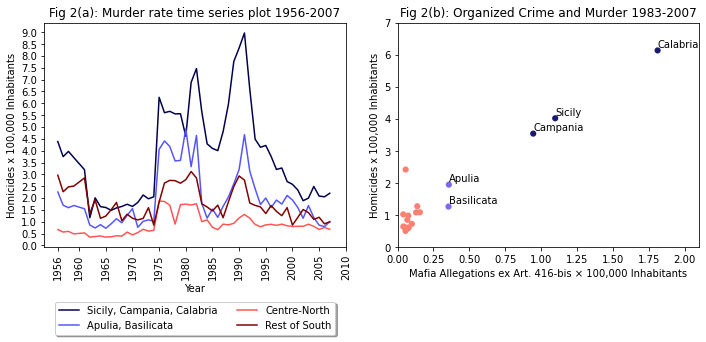

In [5]:
df3 = plot_prep("df3")
fig2_murder_rate_graphs(plot_prep("df3"), df2)

Figure 2(b) illustrates a near-perfect linear relationship between the average murder rate and mafia allegations (the number of cases ex Article 416-bis reported to the judicial authority). The three traditional strongholds of mafia (Sicily, Campania, and Calabria) have some of the highest rates of murder as well as mafia allegations, whereas a cluster of other regions are relatively safe in this regard. This re-affirms the use of homicide statistics as a measure of the presence of organized crime.

At the same time, the analysis of the time series of homicide rates in Figure 2(a) shows significant co-movement amongst regions with an active mafia presence. We can split the observable pattern into four regions. First is the historically mafia plagued regions of Sicily, Calabria, and Campania, which also constitute the Excluded group. The second group is composed of Apulia and Basilicata, the two treatment regions exposed to mafia activity from the 1970s. Finally, there are two residual groups, one for the rest of the Southern regions (Abruzzo, Molise and Sardinia) and one for the Centre-North regions (Piedmont, Aosta Valley, Lombardy, Trentino Alto Adige, Veneto, Friuli Venezia Giulia, Liguria, Emilia Romagna, Tuscany, Umbria, Marche, Lazio). 

We observe that from 1975 onwards, the regions of Apulia and Basilicata go from having a murder rate in line with the rest of the well-performing regions, at times even lower, to experiencing sudden spikes in murders that mirror the same trend of the historically mafia-plagued group. These trends further motivate the choice of focusing on the homicide statistics as an indicator for mafia presence that is more reliable than the Article 416-bis statistic.


---
# 3. Application of Synthetic Control Method <a name="8"></a>

With the empirical motivation and strategy in order, we can now implement the SCM with the goal of replicating the donor unit weights obtained by Pinotti (2015) in his STATA implementaion. 

Given the popularity of synthetic control methods, it surprising that there currently do not exist adaptions of the popular [*Synth*](https://cran.r-project.org/web/packages/Synth/Synth.pdf) packages (STATA, MATLAB, R) nor [*MSCMT*](https://cran.r-project.org/web/packages/MSCMT/index.html) (R) for Python. Therefore, this section is dedicated to writing Python equivalents of the SCM optimization problem drawing on Python's rich scientific libraries. We progressively enhance these functions with ideas gleaned from some of the aforementioned packages, with an emphasis on gradually building the several optimization steps involved in the process. 

We start by preparing the data according to the main specification in the paper.

In [ ]:
treat_unit, treat_unit_all, control_units, control_units_all, y_treat, y_treat_all, y_control, y_control_all, Z1, Z0, X0, X1, w_pinotti, w_becker, v_pinotti, v_becker = data_prep_1(data)

## 3.1. Optimization Objective: A Simplified Problem <a name="9"></a>

We begin our SCM implementation with the simplifying assumption that the predictor variables matrix $V$ is just a diagonal matrix of 1/8, where eight is the number of predictors in our case. This implies that each predictor $k$ is given equal importance in the calculation of the weights for the donor pool. This assumption facilitates an initial understanding of the method and the various optimization tools we can use to implement it in Python. Moreover, it also forms the basis of the later, more complex, optimization functions.

The objective function is given by:

(1) $$
\hat{\boldsymbol{W}}=\operatorname{argmin}_{\boldsymbol{W}}\left[\sum_{i=1}^{k}\left(x_{i1}-\sum_{j=2}^{J+1}\boldsymbol{w}_{j} \boldsymbol{x}_{ij}\right)^{2}\right]
$$

subject to
                                                      
$$ \sum_{j=2}^{J+1}\boldsymbol{w}_{j}=1$$   

where $w_j$ are the 15 weights, one for each of the control regions that together form the 'donor pool', $i$ indicates the predictors and $j$ the regions. 

Which linear combination of donor units' pre-intervention predictor values best resembles the predictor values of the treated unit? Exploiting the `CVXPY` package for convex optimization, we build an initial `CVXPY` setup and we solve the simplified problem to obtain the following output weights.


In [ ]:
def w_optimize(v_diag,solver=cp.ECOS):
    
    V = np.zeros(shape=(8, 8))
    np.fill_diagonal(V,v_diag)
    
    W = cp.Variable((15, 1), nonneg=True) ## Creates a 15x1 positive nonnegative variable
    objective_function    = cp.Minimize(cp.norm(V @ (X1 - X0 @ W)))
    objective_constraints = [cp.sum(W) == 1]
    objective_problem     = cp.Problem(objective_function, objective_constraints)
    warnings.filterwarnings("ignore")
    objective_solution    = objective_problem.solve(solver, verbose=False)
    
    return (W.value,objective_problem.constraints[0].violation(),objective_solution)

w_basic = cvxpy_basic_solution(control_units, X0, X1)


The CVXPY minimization problem allocates weights to the regions of Veneto (VEN: 0.152) and Molise (MOL: 0.848), whereas Pinotti (2015) allocates weights to Abruzzo (ABR: 0.624) and Molise (MOL: 0.376). Becker and Klößner's (2017) response paper found weights for Abruzzo (ABR: 0.43035), Molise (MOL: 0.48934) and Sardinia (SDR: 0.0803045).

Furthermore, a breakdown across predictors for the synthetic controls is shown in the following table. Here, we only show the results for Pinotti's (2015) weights and our CVXPY weights obtained from the simplified CVXPY optimizer (a more complete comparison featuring Becker and Klößner's *MSCMT* weights is reported in Section 5). The first column contains the aggregated observed values in the matching period, the 2nd and 3rd columns contain the predicted values corresponding to the Pinotti *Synth* implementation and CVXPY region weights respectively, and the last two columns report the difference between the observed and synthetic predicted values.


In [ ]:
data_compare_df(w_basic, X0, X1, w_pinotti)

VA denotes sectoral shares of value added for each of the given sectors. We observe that our optimizer reports a lower absolute differential for the indicators for GDP per capita, human capital, and population density. But on the most part, the synthetic control constructed by Pinotti and by CVXPY remain close with minor differences. 

To put this all together, Figure 3 offers a visualization of the actual performance of our synthetic control, compared to the performance of Pinotti and  Becker and Klößner's synthetic controls.

#### Figure 3: Evolution of observed GDP per capita vs. synthetic estimates across different donor weights

In [ ]:
fig3_dynamic_graph(w_basic, w_pinotti, w_becker, y_control_all, y_treat_all, data)

As expected, the different sets of region weights result in different trajectories of the corresponding synthetic controls. This is most notable around the time when drug smuggling spurred by mafia activity reached its peak in 1975. On average, Pinotti's weights suggest the largest gaps in GDP per capita between the treated unit and synthetic control, whereas Becker and Klößner's calculation is less optimistic in regards to the counterfactual's levels of GDP per capita.

Certainly, not all of the three synthetic controls can be used for inferring the economic costs associated with organized crime. This is because inference using the SCM hinges on the capability of the underlying implementation to correctly identify the optimal set of weights so that the synthetic control closely resembles the pre-intervention treatment unit with respect to both the outcome variable and the predictor variables. Therefore, as in Becker and Klößner (2017), we now compare the methods' root mean square prediction error (the 'outer' objective function) to assess which one provides the optimal weights.
 
Root Mean Square Prediction Error (RMSPE) is defined as:

$$\begin{equation}
\text{RMSPE} = \sqrt{\frac{1}{n} \cdot \sum_{t=1}^T \left({y_{t}-\hat{y}_{t}} \right) ^2 }
\end{equation}$$


In [ ]:
def RMSPE(w):
    return np.sqrt(np.mean((Z1 - Z0 @ w)**2)) 

The RMSPE for the CVXPY optimizer, the Pinotti STATA *Synth* implementation, and Becker and Klößner's R/MSCMT optimizers are reported in the table below. Using RMSPE minimization as a quality of result indicator, Becker and Klößner's solution for the weights vector appears to be the best one.


In [ ]:
RMSPE_compare_df(Z1, Z0, w_basic, w_pinotti, w_becker)

Our obtained weights $w$ cannot be optimal since there exist weights $w^{*}$ such that 

(2) $$RMSPE(w) > RMSPE(w^{*})$$

The fact that the RMSPE is much higher when assuming equal weights is in line with our economic intuition. In particular, we should expect that in an advanced economy like Italy, factors such as share of value added by market services, human capital, and investment rate would be more interconnected with economic prosperity than, say, population density. This is because these factors would in theory increase economic productivity and thus increase output. Therefore, it is unsurprising that forcing all factors to have equal weights results in a higher RMSPE.

This means there is room for improvement in the optimization algorithm. Assuming equal predictor importance by setting $V$ as a diagonal matrix of 1/8's simplifies the problem to single variable optimization, but at the cost of reliability of the result. Therefore, we proceed by augmenting the objective function with the relative importance of each of the 8 predictors $k$.

## 3.2. Optimization with Addition of Predictor Importance <a name="10"></a>

### 3.2.1. The choice of $V$ matters <a name="11"></a>
To account for the heterogeneity in the effect of the 8 predictor variables on the outcomes $Y$ (GDP per capita in Pinotti's case), Abadie and Gardeazabal (2003) proposed augmenting the optimization objective with a $(k × k)$ diagonal matrix $V$, such that the diagonal elements are weights indicating the relative importance of each of the predictors. The problem becomes,


(3) $$W^*(V)={\operatorname{arg}}\min _{W \in \mathcal{W}}\left(X_{1}-X_{0} W\right)' V\left(X_{1}-X_{0} W\right)$$ 

Equation (3) is the 'inner' optimization objective with the goal of minimizing the distance between the predictor values of the $J$ donor units, the $(k × J)$ matrix $X_{0}$, and those of the treated unit, the $(k × 1)$ vector $X_{1}$ given predictor importance weights $V$.

(4) $$V={\operatorname{arg}}\min _{V \in \mathcal{V}}\left(Z_{1}-Z_{0} W^*(V)\right)' \left(Z_{1}-Z_{0} W^*(V)\right)$$

Equation (4) is the 'outer' optimization objective to find the optimal diagonal matrix of predictor weights $V$ that minimize the RMSPE of the outcome variable $Y$ in the pre-intervetion period (Becker and Klößner, 2018:4). So the diagonal elements themselves become part of the optimization steps in the calculation of the synthetic controls. Moreover, they are subject to their own constraints, namely that $V$ is a subset of all positive semi-definite diagonal matrices, such that the diagonal elements sum to one (Malo et al.,2020:4):

$$V \in\left\{\operatorname{diag}(V): V \in \mathbb{R}^{K \times K}, \sum_{k=1}^{K} V_{k k}=1, V_{k k} \geq 0\right\}=: \mathcal{V}$$

Moving away from the equal weights assumption of the previous section increases the task's complexity considerably. As Malo et al. (2020:4) remark, "A closer examination of the SCM problem [...] reveals that the SCM problem is far from trivial from the computational point of view.".

To explore this complexity, we consider two approaches that build on the optimizer in the previous section: first, by iterating over a subset of $\mathcal{V}$ and, second, by comparing it to a nested optimization algorithm. 

### 3.2.2. Approach 1: Iterating over a subset of $\mathcal{V}$ <a name="12"></a>

The first approach allows us to integrate the concept of predictor importance into our optimizer whilst still maintaining the tractability of optimizing a single objective. We proceed by continuously drawing the diagonal elements of $V$ from the Dirichlet distribution in order to satisfy that the predictors weight must sum to 1 and then take these as given predictor weights when optimizing over the objective in (3).

Fortunately, Python is well-equipped for this task due to its rich variety of Quadratic Programming solvers which can be used to solve constrained minimization problems as in (3). We use packages `CVXPY` and `scipy.minimize` which offer convenient wrappers to implement some of these methods. In particular, the selected optimization algorithms tested are as follows:
- `CVXPY`: CPLEX, SCS, ECOS 
- `Scipy.optimize`: SLSQP

The aim is to see which method yields the RMSPE minimizing weights as a solution to (3). To that extent, we compare RMSPEs across 50000 iterations and then plot them. At the same time, the reliability of these results is also key, and so we also check for violations of the given constraints across the iterations.

In [ ]:
n = 50000
initial_w = [0]*15
bnds = ((0, 1),)*15
objective_constraint = ({'type': 'eq', 'fun': lambda x: 1.0 -  np.sum(x)})
iteration_2 = []

def objective_function(W,X1,X0,v_diag):
    V = np.zeros(shape=(8, 8))
    np.fill_diagonal(V,v_diag)
    obj_value = LA.norm(V @ (X1.ravel() - X0 @ W))
    return obj_value

def iterate_function(x):
       
    np.random.seed(x)
    v_diag  = np.random.dirichlet(np.ones(8), size=1)
    
    w_ECOS,  csv_ECOS   = w_optimize(v_diag,solver=cp.ECOS)[0:2]
    w_SCS,   csv_SCS    = w_optimize(v_diag,solver=cp.SCS)[0:2]
    w_CPLEX, csv_CPLEX  = w_optimize(v_diag,solver=cp.CPLEX)[0:2]
    
    w_SLSQP = optimize.minimize(objective_function,initial_w,args=(X1,X0,v_diag),method='SLSQP',bounds=bnds,
                        constraints=objective_constraint,tol=1e-10,options={'disp': False}).x.reshape(15,1)
        
    RMSPE_ECOS    = RMSPE(w_ECOS) 
    RMSPE_SCS     = RMSPE(w_SCS) 
    RMSPE_SLSQP   = RMSPE(w_SLSQP)
    RMSPE_CPLEX   = RMSPE(w_CPLEX)
    
    output_vec  = [v_diag, RMSPE_ECOS,RMSPE_SCS,RMSPE_CPLEX,RMSPE_SLSQP,w_ECOS,w_SCS,w_CPLEX,w_SLSQP,
                  csv_ECOS,csv_SCS,csv_CPLEX]

    return output_vec
    
iteration_2 = Parallel(n_jobs=-1)(delayed(iterate_function)(x) for x in list(range(1,n+1)))
solution_frame_2 = pd.DataFrame(iteration_2)
solution_frame_2.columns =['Predictor Importance', 'RMSPE ECOS','RMSPE SCS','RMSPE CPLEX','RMSPE SLSQP',
                           'ECOS Weights', 'SCS Weights', 'CPLEX Weights', 'SLSQP Weights',
                           'ECOS Violation', 'SCS Violation', 'CPLEX Violation']

#### Figure 4: Minimum RMSPEs with increasing iterations and the average violations of the sum constraint 

In [ ]:
V_iterative(solution_frame_2, control_units)


We argued in the previous section that assuming equal predictor importance weights did not seem reasonable from an economic standpoint. As it turns out, factors which we would expect to be more correlated with GDP in a developed economy like Italy's have the most weight in the best vector of diagonal elements, $v^*$ found in this iteration exercise. In fact, this $v^*$, which minimizes the value of the outer objective across all iterations, assigns relatively larger weights to human capital and industry's share of value added. Such factors would in theory boost economic productivity and thus GDP, which gives us economic intuition behind the SCM. 


Overall, the solvers ECOS, CPLEX, SLSQP, and SCS perform comparably across the iterations of $V$ as shown by their significant co-movement in Figure 4(a), which plots the minimum RMSPE (value of the outer objective function) recorded as the number of iterations increases. However, SCS is prone to deviations from this general path and tends to record lower RMSPE at the cost of larger constraint violations. At first there is significant gain from increasing the number of iterations denoted by the large drops in RMSPE. But as the iterations approach 40,000, these gains diminish until eventually stabilizing, perhaps at some local minima found in the subset of $\mathcal{V}$ under consideration. In fact, the exact iteration where most solvers record their lowest RMSPE is iteration 36287, when the diagonal elements of $V$ consist of $v^*$. The corresponding $W^*$ in the above table are comparable across all the solvers and they assign weights to Abruzzo, Molise, and Sardinia with minor differences in their weightings.  


Whilst the value of the outer objective provides a way to compare these methods, it is equally important to assess the extent of their constraint violations from a reliability standpoint. In problem (3), the sum of the solution vector $w$ is constrained to one. It is evident from Figure 4(b) that ECOS records the lowest mean value of constraint violations across all iterations and SCS the highest mean value. Furthermore, these violations are also present in the optimal values for SCS, ECOS, and CPLEX (checking this violation is not possible via `scipy.optimize` for SLSQP). 

In this subsection, we have surveyed four methods to compute the region weights in our quadratic optimization problem and have shown that they all perform at similar levels in regards to finding the optimal vector of weights. Notably: 
- Augmenting our initial optimization function with the relative importance of predictors improves its performance.
- The $W^*(V^*)$ obtained from these methods suggests lower RMSPE compared to Pinotti (130.14095) but these are not valid solutions due to the violation of the condition of $W^*$ summing to one. 
- Therefore, iterating over a subset of $\mathcal{V}$ is, ultimately, a time consuming and unreliable method with no guarantee that the optimal predictor importance weights lies in this subset.
- These deficiencies call for a faster and more reliable way of approaching the problem.

### 3.2.3. Approach 2: Nested Optimization <a name="13"></a>

To improve our optimization function, we draw on insights from recent popular implementations of SCM. These include Hainmueller's [Synth](https://cran.r-project.org/web/packages/Synth/Synth.pdf) package in R and its adaptions to MATLAB and STATA, as well as the more recent [R/MSCMT](https://cran.r-project.org/web/packages/MSCMT/index.html) package of Becker and Klößner (2018). Although these packages do not have adaptions for Python, we can draw on some of their main insights and adapt them.

Our particular focus is the R/MSCMT package since it offers a generalization of the SCM in a way that addresses the instabilities and shortfalls of existing implementations in R (Becker and Klößner, 2018). This package has several optimization algorithms, including one that uses a combination of outer optimization via Differential Evolution and inner optimization via [DWNNLS](https://www.netlib.org/slatec/src/dwnnls.f) (Weighted Non-Negative Least Squares). This corresponds to the default option 'DEoptC' in the call to R/MSCMT's solver. The Fortran implementation of the WNNLS algorithm was presented by Hanson and Haskell (1982), and was later adapted to R in the package limSolve (Becker and Klößner, 2018:14). WNNLS is a reliable and fast inner optimizer for the nested optimization problem of SCM and, interestingly, which the authors of R/MSCMT enhance with a further speed boost by using Fortran-calls to WNNLS in a C-implementation (Becker and Klößner, 2018:18).

We can adapt some of these ideas using Python's existing libraries. Differential Evolution for the outer optimization is available via the `scipy.optimize` library, however Python currently does not have a wrapper for WNNLS. Therefore, we instead use ECOS via `CVXPY` as the default solver because the analysis from the previous section showed that this solver performed comparatively better from a reliability standpoint. And finally, to add some flexibility to this approach, we insert our optimization method into a configurable function with a built-in data-preparation tool. This helps to avoid re-writing code during the later robustness and placebo tests, as we can simply change the configurations as needed.

In [ ]:
# Setting SCM function arguments as in Pinotti (2015)
unit_identifier     = 'reg'
time_identifier     = 'year'
matching_period     = list(range(1951, 1961))
treat_unit          = 21
control_units       = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20]
outcome_variable    = ['gdppercap']
predictor_variables = ['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']
entire_period       = list(range(1951, 2008))

output_object = SCM_v1(data,unit_identifier,time_identifier,matching_period,treat_unit,control_units,
                    outcome_variable,predictor_variables)

w_nested = output_object[1]
v_nested = output_object[2]

SCM_print(data,output_object,w_pinotti,Z1,Z0)


Our SCM( ) implementation has replicated the weights obtained by Pinotti's STATA implementation in a faster and more reliable manner than our previous iterative approach. 

As a result, the outer objective function values are approximately equal. We also observe that the corresponding $V^*$ allocates the higher weights to investment rate, industry share of value added, and non-market services share of value added. The relatively large weight on investment rate is especially unsurprisngly since, from an economic standpoint, we expect investment in an economy to be highly correlated with output as seen in standard growth models in macroeconomics.

## 3.3. Feasibility of the Unrestricted Outer Optimum and the Computational Challenges of SCM <a name="14"></a>

####  *Estimating the economic costs of organized crime by synthetic control methods* (Becker and Klößner, 2017)

Although our SCM nested optimizer has replicated the Pinotti (2015) weights, the response paper by Becker and Klößner (2017) to Pinotti (2015) still remains the benchmark for this analysis. The authors used Pinotti's dataset and specification to compare RMSPE-minimizing solution vectors (vector of weights of donor pool) across several software implmentations (STATA, MATLAB, R/Synth, R/MSCMT).

They find that different software implementations produce slightly different results, but the one that produces the RMSPE minimizing set of weights is from their own R/MSCMT package. Due to the RMSPE minimizing property, they term this vector of weights as the "correct" one for constructing a synthetic control for Apulia and Basilicata. The resulting GDP per capita gaps between the treated region and its synthetic control are marginally smaller than Pinotti's synthetic control computed from STATA. Consequently, the authors conclude that the loss in GDP per capita due to the presence of mafia in the affected regions has been slightly overestimated by Pinotti, being 13% instead of Pinotti's 16%.

The authors further state that Pinotti's paper is a practical example of an SCM application where the unrestricted global optimum is feasible. Therefore, it appears that the suboptimal RMSPE of 130.14095 from Pinotti's weights is the result of the STATA package failing to check for the global optimum and thus delivering a local optimum instead.

The global optimum $W^{**}$ is the solution to the outer objective (4) such that we impose no additional constraints other than  the donor unit weights summing to one. Then, to check whether there exists predictor importance weights $V \in \mathcal{V}$ that support these weights, we solve as in Malo et al. (2020:8):

(5) $$V(W^{\star \star})={\operatorname{arg}}\min _{V \in \mathcal{V}}\left(X_{1}-X_{0} W^{\star \star}\right)^{\top} V\left(X_{1}-X_{0} W^{\star \star}\right)$$

This objective is the same as the inner objective of (3) except we now take the donor weights $W$ as given and solve for predictor weights $V$, such that the predictor weights sum to one. We attempt to replicate this unrestricted outer optimum and check its feasibility by adapting the R-codes used for this purpose in Kuosmanen et al. (2021:41).

We prepare the data by normalizing X.

In [ ]:
X0_scaled, X1_scaled, Z0_float, Z1_float = data_prep(data,unit_identifier,time_identifier,matching_period,treat_unit,control_units,outcome_variable,predictor_variables, normalize=True)

In [ ]:
# Parameter Setup
Tpre     = Z0.shape[0] 
nDonors  = Z0.shape[1]
nvarsV   = X0.shape[0]

# Quadratic Programming setup
c1 = (-Z0_float.T @ Z1_float).reshape(nDonors,)
H1 = Z0_float.T @ Z0_float  
A1 = np.ones((nDonors,1)).reshape(nDonors,)
b1 = np.ones((1,1)).reshape(1,)
l1 = np.zeros((nDonors, 1)).reshape(nDonors,)
u1 = np.ones((nDonors, 1)).reshape(nDonors,)

# Quadratic Programming Execution: Outer Objective Function 
w_cvxopt = solve_qp(P = H1, q = c1, A = A1, b = b1, lb = l1, ub = u1, solver='cvxopt').reshape(nDonors,1)

L1_cvxopt = (Z0_float.T @ Z1_float)/Tpre + 2/Tpre * (c1.T @ w_cvxopt + 0.5 * w_cvxopt.T @ H1 @ w_cvxopt) 

# Inner Objective Function: Do there exist predictor weights that support W*?
V = cp.Variable((8, 1), nonneg=True)
objective_function    = cp.Minimize(cp.sum_squares(cp.multiply(V,X1_scaled - X0_scaled @ w_cvxopt)))
objective_constraints = [cp.sum(V) == 1]

objective_problem     = cp.Problem(objective_function, objective_constraints).solve(solver=cp.OSQP)
v_OSQP = V.value.ravel()

objective_problem     = cp.Problem(objective_function, objective_constraints).solve(solver=cp.ECOS)
v_ECOS = V.value.ravel()

objective_problem     = cp.Problem(objective_function, objective_constraints).solve(solver=cp.CPLEX)
v_CPLEX = V.value.ravel()

objective_problem     = cp.Problem(objective_function, objective_constraints).solve(solver=cp.SCS)
v_SCS = V.value.ravel()

global_feasible(Z1,Z0, w_cvxopt,L1_cvxopt,control_units,data,w_becker,v_OSQP,v_CPLEX,v_ECOS,v_SCS)

The package `qp_solve` includes a wrapper for CVXOPT which can be used to solve the Quadratic Programming problem of finding the global optimum $W^{\star \star}$. Unlike `CVXPY` and `scipy.optimize`, this solver does not struggle with the sum constraint. The obtained optimal weights match the 'correct' ones reported by Becker and Klößner (2017) from their R/MSCMT package in their response paper.

For Objective (5) some of the solvers struggle with the sum contraint for $V$ and surprisingly only OSQP obeys the constraint. On the one hand, this result is surprising because only a particular combination of state-of-the-art solvers in the form of CVXOPT and OSQP was able to deliver a reliable and precise result without constraint violations. On the other hand, the result also means there do exist predictor weights $V$ that satisfy the $W^{\star \star}$, which concurs with the finding of Becker and Klößner (2017) that the unrestricted global optimum is feasible in Pinotti's SCM application to organized crime in Italy.

The existence of a feasible unconstrained global optimum in the case of Pinotti (2015) further substantiates the claim by Malo et al. (2020:6) that a surprisingly large amount of SCM problems encountered in practice admit either an unconstrained solution or a corner solution. Yet the Becker and Klößner (2017) response paper reports that STATA, MATLAB, and R/Synth all provided suboptimal donor weights whilst only R/MSCMT provided the correct minimizing value of 128.94856 using the unrestricted global optimum. To reconcile these differences, we turn to recent literature (Klößner et al., 2018, Kuosmanen et al., 2021) which have both reiterated the numerical instability of the Abadie et al. (2011) *Synth* algorithm. Specifically, Kuosmanen et al. (2021:1) claim that *Synth*, (used by R, MATLAB, and STATA), can produce synthetic control weights that are potentially numerically unstable and suboptimal (where even reordering the weights can have a major effect on the results).

At the same time, it should be noted that Kuosmanen et al. (2021:21) do not encourage the practical use of the global optimum and they only calculate the global optimum in their empirical examples to highlight the computational failure of *Synth*. This is because it can be the case that the globally optimal weights results in a poor empirical fit that disregards all predictors except for one. For example, in their re-analysis of the Abadie's et al. (2010) study on California’s tobacco control program, Kuosmanen et al. showed that the global optimum allocated the entire predictor weight ($v$ = 1) to only "Cigarette sales per capita 1980". Similarly, in replicating Pinotti's study, we found that `OSQP` allocated almost the entire weight ($v$ = 0.941) to GDP per capita.

This discussion highlights the vast complexities associated with optimizing a synthetic control in an empirical context. In such a context, causal inference hinges crucially on the underlying computational algorithm's ability to provide weights so that the synthetic control resembles the pre-treatment treated units as close as possible. And so when underlying SCM implementations fail to deliver the optimal result in a reliable way, the credibility of the causal interpretation can be called into question. In this regard, Kuosmanen et al. (2021:2) assert that this sub-optimality could compromise the qualitative results of, "several thousands of SCM applications". As we have seen, this was also the case in this project where Pinotti's estimate of the causal effect of organized crime on GDP per capita was overestimated by 2% (16% as opposed to 14%) due to the failure of the STATA/EJ package to provide the feasible unrestricted global optimum.

<br>
<br>
With our new-found insights obtained from the current frontiers of research on the SCM, our own SCM( ) implementation has now been augmented with the functionality for normalizing $X_{0}$ and $X_{1}$ predictor matrices (as recommended by Becker and Klößner (2018)) as well as the ability to check for the global optimum. Given that Kuosmanen et al. (2021:21) do not advocate for the pratical use of the global optimum, the argument for checking the global optimum is defaulted to 'False'.

Here is a brief demonstration of the refined SCM( ) implementation using the original specification:

In [ ]:
# Original Specification
unit_identifier     = 'reg'
time_identifier     = 'year'
matching_period     = list(range(1951, 1961))
treat_unit          = 21
control_units       = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20]
outcome_variable    = ['gdppercap']
predictor_variables = ['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']
entire_period       = list(range(1951, 2008))

# Call to SCM( ) using above arguments, with and without the option for checking the global optimum. 
output_object_1 = SCM(data,unit_identifier,time_identifier,matching_period,treat_unit,control_units,
                    outcome_variable,predictor_variables,check_global = False,normalize=True)

output_object_2 = SCM(data,unit_identifier,time_identifier,matching_period,treat_unit,control_units,
                    outcome_variable,predictor_variables,check_global = True,normalize=True)

# Save and print output
w_nested = output_object_1[1]
w_global = output_object_2[1]
print('\nRMSPE Check Global False: {} \nRMSPE Check Global True:  {}'\
      .format(np.round(RMSPE(w_nested),5), np.round(RMSPE(w_global),5)))

Setting *check_global* to **True** identifies the RMSPE-minimizing set of global optimum weights, whilst setting it to **False** results in a sub-optimal solution. As we now know from the previous section, there is a feasible global optimum.

---
# 4. Robustness of our SCM Implementation <a name="15"></a>

In this section we investigate the two-pronged robustness of our SCM implementation using its built-in data preparation functionality. This is done by first testing two additional datasets and then highlighting a potential vulnerability from reordering donors.

## 4.1. Application to Alternative Empirical Cases <a name="16"></a>
In this section we show the generality, feasibility and robustness of our SCM( ) nested optimizer implementation in Python through its application to two of Abadie's previous works on synthetic control methods. Applying our SCM( ) method to the respective datasets allows to confront the weights obtained by Abadie in his two works with the ones resulting from our application.

### 4.1.1. The Economic Costs of Conflict: A Case Study of the Basque Country (Abadie and Gardeazabal, 2003)<a name="17"></a>
In their seminal application of the synthetic control method to the Basque Country of Spain, Abadie and Gardeazabal (2003) investigate the economic costs of a terrorist outbreak in the late 1960s to the Basque Country. They exploit control units from 16 donor regions in Spain to build a synthetic control for the GDP per capita of the Basque Country.

After the preparation of the dataset and setting of the necessary parameters, we proceed with the application of our SCM( ) method to the Basque dataset to get the following output.

In [ ]:
# Load BASQUE data and Variable transformations necessary for exact replication.
data_Basque = pd.read_csv ('./dataset/Pinotti-replication/basque_data.csv')

data_Basque['school.sum'] =  (data_Basque['school.illit'] + data_Basque['school.prim'] + 
                              data_Basque['school.med'] + data_Basque['school.high']  + 
                              data_Basque['school.post.high'])

data_Basque['school.higher'] = data_Basque['school.high'] + data_Basque['school.post.high']

for var in ["school.illit", "school.prim", "school.med", "school.higher"]:    
    data_Basque[var] = 6 * 100 * ((data_Basque[var]).T / data_Basque['school.sum']).T

# Parameter specification as in Abadie and Gardeazabal (2003)
unit_identifier_basque     = 'regionno'
time_identifier_basque     = 'year'
matching_period_basque     = list(range(1960, 1970))
treat_unit_basque          = 17
control_units_basque       = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
outcome_variable_basque    = ['gdpcap']
predictor_variables_basque = ['school.illit', 'school.prim', 'school.med', 'school.higher', 'invest', 
                              'gdpcap', 'sec.agriculture', 'sec.energy', 'sec.industry', 'sec.construction',
                              'sec.services.venta', 'sec.services.nonventa','popdens']
entire_period_basque       = list(range(1955, 1998))

# SCM( ) implementation
output_object_basque = SCM(data_Basque, unit_identifier_basque,time_identifier_basque,matching_period_basque,
                           treat_unit_basque,control_units_basque,outcome_variable_basque,predictor_variables_basque,
                           dataprep=True,normalize=True,solver=cp.ECOS)
basque_weights(output_object_basque,data_Basque,control_units_basque)

The table above shows that our default nested optimizer yields resulting donor weights which are exactly identitical to the ones from the original paper, highlighting that our SCM( ) has more broader applicability than just Pinotti's (2015) dataset.

### 4.1.2. Comparative Politics and the Synthetic Control Method (Abadie, Diamond and Hainmueller, 2015)<a name="18"></a>
The SCM application in Abadie et al. (2015) estimates the effect of the 1990 German reunification on the GDP per capita of West Germany. In this case, the treated unit is former West Germany, and the donor pool consists of 16 industrialized OECD member countries used to build a synthetic counterfactual of West Germany's performance in the absence of unification.

As above, we proceed by setting the necessary parameters to apply our SCM( ) method to the Reunification dataset.

In [ ]:
# Parameter specification as in Abadie, Diamond and Hainmueller (2015)
data_reuni = pd.read_stata('./dataset/Pinotti-replication/GermanReunification.dta')
unit_identifier_reuni     = 'index'
time_identifier_reuni     = 'year'
matching_period_reuni     = list(range(1980, 1991))
treat_unit_reuni          = 7
control_units_reuni       = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 19, 20, 21]
outcome_variable_reuni    = ['gdp']
predictor_variables_reuni = ['gdp','infrate','trade','schooling','invest60','invest70','invest80','industry']
entire_period_reuni       = list(range(1960, 2004))

X0_reuni,X1_reuni,Z0_reuni,Z1_reuni = data_prep(data_reuni,unit_identifier_reuni,time_identifier_reuni,
                                                matching_period_reuni,treat_unit_reuni,control_units_reuni,
                                                outcome_variable_reuni,predictor_variables_reuni, normalize = False)

# SCM( ) implementation
output_object_reunification = SCM(data_reuni,unit_identifier_reuni,time_identifier_reuni,matching_period_reuni,treat_unit_reuni,
                                  control_units_reuni,outcome_variable_reuni,predictor_variables_reuni,
                                  dataprep=True, normalize=True,solver=cp.ECOS)
reunification_weights(output_object_reunification,data_reuni,Z0_reuni,Z1_reuni)

The resulting weights comparison is reported is the table above. The weights computed by SCM( ) nested optimizer identify exactly the same donor regions as Abadie's et al. (2015) paper, although the weightings of these regions differ. This difference may be due to the cross-validation algorithm of identifying predictor weights $V$ used in the paper. However, our nested optimization generates a smaller value of the outer objective function value (RMSPE), suggesting a possibly improved empirical fit of the resulting synthetic control.

## 4.2. Numerical Instability in Implementation: Sensitivity to Random Reordering of Donors<a name="19"></a>
Although the previous applications showcase the robustness of our method to different empirical settings, it is worth noting that SCM( ) still has room for improvement. Referring back to the previous section's survey of the computational challenges of SCM, we were surprised to learn from Kuosmanen et al. (2021:2) that simply reordering donors and predictors can cause major changes to the results from the popular *Synth* algorithm. According to Kuosmanen et al. such random reordering of either the rows or columns of the data matrix should not in any way affect the true optimal solution to the SCM problem. 

However, like *Synth*, our implementation is also vulnerable to this issue. We compare the results obtained using the original ordering of predictors and donors from Pinotti (2015) and Becker and Klößner (2017), with those obtained by SCM( ) when randomly reordering the predictors. Following an experiment in Kuosmanen et al. (2021:8), we draw 10 random orderings of the rows of matrix $X$. To maintain comparability, all other features of the original data and its specification are kept the same.

In [ ]:
numerical_instability(Z0,Z1,X0,X1,data,v_pinotti,v_becker,w_becker,w_pinotti)

The first two columns are the weights obtained by *Synth* and *MSCMT* packages in R respectively. These data were sourced from Becker and Klößner (2016). The last three columns are statistics of our SCM implementation across 10 random orderings of the predictors. 

As the table shows, our SCM obtained weights change across different random permutations of the predictor variables. The predictor weights $v$ are volatile across these permutations, although the region weights $w$ for Abruzzo, Molise, and Sardinia remain somewhat stable. In fact, in some of these cases, the permutations even result in the RMSPE-minimizing set of weights. This shows that there is still some numerical instability in our method.

---
# 5. Synthetic Control Performance Analysis<a name="20"></a>
With the SCM( ) robustness analysis now completed, we assess its performance from an empirical standpoint with emphasis on the differences created by the local optimum and global optimum. We have seen that using a nested optimization algorithm with Differential Evolution for the outer objective and constrained minimization for the inner objective proves to be a fruitful strategy as we obtain Pinotti's sub-optimal weights. At the same time, our global optimum algorithm succesfully identifies the correct optimal donor weights from Becker and Klößner (2017). 

Interestingly, Pinotti's (2015) result using STATA's Synth package only attributes weights to Abruzzo and Molise. The author argues that this enhances the credibility of the synthetic control method as it picks those regions that are close to the treatment regions, in a country where broad supraregional territories are known to share economic development characteristics. Therefore, following this reasoning it is surprising that our SCM( ) global optimum algorithm and R/MSCMT optimizer both assign a significant positive weight to Sardinia, an off-coast island of Italy with peculiar characteristics.

To get a better idea of how well the synthetic controls constructed from these different weights match the true treated unit, we compare their resulting predicted values with the true values across all 8 predictors over the matching period.

In [ ]:
table_compare_2(w_nested,w_global,data,predictor_variables,w_becker,w_pinotti,X1,X0)

The first column shows the true aggregated values of predictors during the matching period. The 2nd and 3rd columns are the predicted values using Pinotti's (2015) local optimum weights and Becker and Klößner's (2017) global optimum weights. The 4th and 5th columns are the corresponding weights as replicated by SCM( ). The final three columns are descriptive statistics for the donor pool regions from which the synthetic control is constructed. 

In general, we see similar values across the board. The global optimum synthetic control obtained by MSCMT and SCM( )/Global is closer to Apulia and Basilicata in terms of Investment Rate, Industry Share of Value Added, and Agriculture Share of Value Added, compared to the local optimum synthetic control of Pinotti and SCM( )/Nested. This is unsurprising since all these predictors were assigned high non-negative importance weights. The largest differences between the local optimum and global optimum are observed for GDP per capita and Population Density.

To understand how these characteristics shape the issue of causality, we plot the predicted evolution of the outcome variable, GDP per capita, for the local optimum (Pinotti, 2015) and global optimum (Becker and Klößner, 2017) weights. Each optimum corresponds to a different counterfactual scenario for the evolution of the outcome variable from which to estimate a causal effect for the treatment. That is, how economic growth would have evolved in Apulia and Basilicata in the absence of mafia presence.

#### Figure 5: Evolution of observed GDP per capita vs. synthetic estimates across Pinotti (2015) weights and global optimum weights

In [ ]:
dynamic_graph_2(w_becker,w_nested,w_pinotti,y_control_all,y_treat_all,data)

We notice three main features.

First is that the observed and synthetic control paths of GDP per capita are largely indistinct from the start of the matching period up till 1975. This is to be expected since the 'treatment' effect of mafia presence only began around 1975 and so the treated unit should still be characteristically similar to its synthetic control unit before this time.

Second, after 1975, the paths begin to diverge with significant co-movement between the predicted values of Pinotti's donor weights, our nested optimizer, and Becker and Klößner's global optimum. Notably, the blue line indicating the path of our nested optimizer weights is not readily visible due to the marginal differences between them and the weights of Pinotti, resulting in considerable overlap.

And finally, the predicted path of Pinotti (2015) lies above the predicted path of the global optimum weights in the post-treatment period, thus indicating a relatively more optimistic counterfactual scenario for Apulia and Basilicata in the absence of mafia. This implies that, on average, Pinotti's synthetic control slightly overestimates the loss in annual GDP per capita arising from organized crime compared to the global optimum synthetic control unit. At their respective peaks, the difference between the two amounts to 2% - 16% in the case of Pinotti (2015) vs 14% for the global optimum weights.

For our last illustration of the empirical distinction between the SCM( ) local and global optimum, we consider how these optima change the differences between their corresponding synthetic control estimate and the treated unit overtime. Specifically, the following figure contrasts the murder rates gaps and GDP per capita gaps between the actual realizations of Apulia and Basilicata and the ones predicted by the synthetic controls (with the gap measured as actual values *minus* predicted values).

#### Figure 6:  Local Optimum vs. Global Optimum: Evolution of gaps between observed and synthetic estimates over time for GDP per capita and Murder Rate series

In [ ]:
diff_data_0 = diff_figure_2(w_nested,w_global,control_units_all,treat_unit_all,y_control_all,y_treat_all,data)

Up until the early 1970s, before the start of the mafia outbreak, the GDP per capita and Murder Rate gap series appear centered around zero for both optima. But in the period following 1975, there is a sharp and positive rise in the difference in murder rate coinciding with the documented mafia outbreak. The two synthetic controls display significant co-movement in this period. This same time period is also marked by a gradual decline in the percentage differences in GDP per capita between the treated unit and the synthetic control. 

Furthermore, whilst the murder rate gap fluctuates in the positive region between 0 and 4 (with the exception of a negative difference in 2005), the decline in the GDP per capita gap is near-persistent over two decades and it stabilizes around -3.5%. It is worth noting that the absolute GDP per capita gap for the local optima (blue bars) is consistently overestimated after 1975 when compared to the GDP per capita gap for the global optima (orange bars). This is consistent with the finding in Figure 5, where the GDP per capita path for Pinotti (2015) lies above that of Becker and Klößner (2017), indicating that the local optima is on average too optimistic about the economic growth prospects in the counterfactual scenario.

Despite these differences, these trends signify that the post 1975 period is marked by substantial increases in the murder rate gap and output level gap between Apulia and Basilicata and its counterfactual. It thus suggests that these regions fall further and further behind from an economic standpoint as the spread of organized crime introduces communal violence and distortionary effects on their economy.

---
# 6. Robustness Checks <a name="21"></a>

## 6.1. Sensitivity Analysis <a name="22"></a>
How do the empirical insights obtained from the previous section, particularly the suggested relationship between organized crime and output gaps, change in response to changing the composition of the treated and control groups? And is it possible that the change in economic outlook for the treated regions (as seen in Figure 6) was being driven by some prior, unobserved exogenous shock other than organized crime and is simply being misattributed as the effect of organized crime?

In exploring the answers to such questions, this section expands on the robustness checks presented in Pinotti's paper to better understand the issue of causality and the sensitivity of the empirical finding to different constructions of the SCM. We apply these constructions using our own SCM( ) implementation and restrict the analysis to the default nested optimizer algorithm since the global optimum is not feasible for all the cases examined.

Below, Figure 7 plots GDP per capita on the left vertical axis (blue bars) and murder rate on the right vertical axis (black lines) for different sets of checks detailed in the title of each graph, following Figure 6 as a blueprint.

#### Figure 7: Sensitivity of observed treatment effect to different specifications of the synthetic control

In [ ]:
multiplot(SCM, data, unit_identifier, time_identifier, matching_period, 
          treat_unit, control_units, outcome_variable, predictor_variables, reps, entire_period)

The first two graphs, (a) and (b), show the result of the synthetic control method when extrapolating either Apulia or Basilicata separately as treated units, instead of combining them into a single treated unit. The relationship between organized crime and GDP per capita in those two regions remains similar to baseline result (see Figure 6). Apulia and Basilicata experienced a dramatic drop in GDP in the same period, which excludes the effects of peculiar shocks only happening to one of them (for instance, the earthquake occuring in Basilicata in 1980), and also indicates the effects of some common factor, which is in this case represented by the mafia outbreak.

Graphs (c), (d), and (e) investigate the robustness of the baseline result to changes in the composition of the control group. We learned in previous sections that the SCM( ) nested solution allocates weights to Abruzzo and Molise, and the global optimum additionally includes Sardinia. This sparsity of the weights is typical of synthetic control estimators. To eliminate the concern that specific regions are driving our findings, these three regions are excluded from the control group one by one. Nevertheless, the results remain robust, further strenghtening the validity of the previous empirical result.

As an additional robustness check we change the predictors' composition. Graph (f) includes crime rates in the predictors while graph (g) includes electricity consumption and theft as predictors and excludes population density, which has been consistently rated with low predictor importance in our optimizations. Lastly, we expand the matching period from the originally proposed 1951-1960 to 1951-1965 in graph (h) and 1951-1975 in graph (i) to explore the possibility of some anticipatory effects leading up to the mafia outbreak in 1975. Each of these attempts also has little effect on the main results.

## 6.2. Placebo Testing<a name="23"></a>
Following the proposed small-sample falsification test of Abadie et al. (2010), Pinotti (2015) proceeds by replicating the above SCM estimates for several pairs of 'false' treatment groups to test the reliability of his result from an inferential standpoint.

The idea is that many pairs of control units can be used as placebo treatment units in place of Apulia and Basilicata and the distribution of the obtained placebo estimates can be plotted against the estimated effect for the true treatment unit. If this latter estimated effect is unique relative to the distribution of several placebo estimates, then, based on the empirical strategy, this uniqueness is not coincidental and can be inferred to be the treatment effect on the true treatment group. In our case, we can reject the null hypothesis that the effect of organized crime on GDP per capita is equal to zero for Apulia and Basilicata.

From a technical standpoint, Pinotti (2015) restricts the set of all possible placebo composites to only those composites consisting of geographically adjacent regions. This is intended to ensure comparability to the true treatment unit by mirroring the fact that it, too, is a composite of two adjacent regions of Apulia and Basilicata. The end result is a total of 23 placebo pairs which we identified from the STATA code in the Pinotti's (2015) replication kit. Moreover, the original specification is applied to these placebo pairs, including setting the matching period from 1951 to 1960 and pretending that they were 'treated' by organized crime in 1975. If we see any significant deviations in GDP per capita and homicide rates occurring during and after this time period for any of the placebos, then it would cast doubt on the validity of the obtained causal effect for the true treatment unit.


#### Figure 8: Observed treatment effect for Apulia and Basilicata and placebo units 

In [ ]:
placebo_plot(g,placebo_groups,diff_data_0)

Figure 8 (a) and (b) show the distribution of the differences between the observed values and their synthetic estimates for GDP per capita and homicide rate for the true treated unit and its placebos.

In (a) we see that up until the early 1970s, the series for the true treatment unit is in line with the placebos. Then, after 1975, the deviations are increasingly negative, indicating that the GDP per capita gaps are growing larger and larger. In fact, the series for the treatment unit appears to form a lower bound for the placebos after 1975. None of the placebos display such a persistent and sharp decline in GDP per capita gaps after their 'treatment'.

A similar pattern arises in (b). It is only after treatment in 1975 that the true treated unit diverges from the rest of the distribution and displays such an abnormal sudden deviation, indicating that the gaps between actual homicides and its synthetic estimates are increasing. It is encouraging to see that these abnormal differences are not observed for the placebos; we do not observe a rise in mafia activity (as measured by homicides) even when pretending that such a treatment did occur.

Taken together, these findings suggest that the estimate for the economic cost of organized crime on GDP per capita for the treatment unit is not observed by chance. It appears to be a consistently irregular pattern not seen in any of the placebo tests and so we can reject the null that the treatment effect equals zero.


---
# 7. Conclusions<a name="24"></a>
This replication of Pinotti's (2015) investigation into the economic costs of organized crime re-affirmed the detrimental impact of criminal syndicates on local economic performance. We began by providing a background on the peculiarities of criminal organizations in Italy and the historical events which brought them to the previously unscathed regions of Apulia and Basilicata, then proceeded with the replication of the main findings in Pinotti's work. In the process, we emphasized the many optimization steps involved in the synthetic control method, as well as some economic intuition behind the method itself. Finally, our brief exploration into recent literature on this method has revealed its computational challenges and weaknesses in some existing software implementations.

Our SCM methodology was built up gradually in a way that addressed the flaws of earlier iterations. We began with a simplified initial setup where we assigned equal weights to each predictor. The poor fit obtained from this method made economic sense because in reality we would expect economic factors such as share per value of industry and market services to be relatively more interconnected with regional GDP, thus highlighting the necessity for heterogenous predictor weights. With this insight in mind, we took the next step of iterating over a subset of the solution set. This procedure was not only time consuming, but also unreliable with no guarantee of an optimal result. However, we gained insight from this exercise by comparing different Python solvers (`CVXPY` solvers ECOS, SCS and CPLEX, and `scipy.optimize` solver SLSQP) and assessing which are best suited to this problem. We progressed by changing the approach to a joint-optimization problem and created a nested optimization algorithm based on the general idea of Becker and Klößner’s (2018) paper. This approach proved much faster and we achieved donor unit weights equal to the weights obtained by Pinotti's (2015) STATA implementation. The computational and mathematical advantages of the nested algorithm were thus evident.

As a point of departure, we also examined a conflicting result by Becker and Klößner’s (2017) response paper and resolved this conflict with insights from recent literature on SCM. As it turns out, the popularly used *Synth* algorithm is highly unstable and unreliable, and this could have repercussions for several thousands of published studies that have relied on this algorithm to estimate causal effects using synthetic control methods. This is also the case for Pinotti (2015), where the economic cost of organized crime was overestimated by 2%.

Given these insights into the practical importance of stability in SCM packages, we then also tested our own SCM( ) implementation using a two-pronged robustness approach. First, we applied it to a couple of datasets from well-known SCM papers by Abadie *et al*.: the Basque Country terrorism outbreak in the 1960s dataset and the 1990 West Germany reunification dataset. The results from this exercise proved the applicability of our method to empirical settings beyond that of Pinotti (2015). Second, we identified a vulnerability in SCM( ) in response to random reorderings of the predictors; an issue also present in the *Synth* package. This raised a concern of the potential numerical instability for our method as well.

Finally, to address the key issue of causality, we tested for the sensitivity of our empirical findings to changes in the compositions of the treated unit, the donor pool, and the predictors. None of these modifications invalidated the estimated effect of organized crime on GDP per capita.

In conclusion, this project motivates the need for SCM implementations with an emphasis on the numerical stability and reliability of its computations. As we have seen, these underlying computations can have a significant impact on estimated causal effects in empirical case studies that use the synthetic control method. Given that such packages already exist for R, it would thus be beneficial to have for Python users as well, especially one that could leverage its plethora of high-quality scientific libraries.

---
# 8. References <a name="25"></a>

-	Abadie, Alberto, Alexis Diamond, and Jens Hainmueller. *Comparative politics and the synthetic control method.* American Journal of Political Science 59.2 (April 2015): 495-510.


-	Abadie, Alberto, and Javier Gardeazabal. *The economic costs of conflict: A case study of the Basque Country.* American economic review 93.1 (2003): 113-132.


-	Abadie, Alberto. *Using synthetic controls: Feasibility, data requirements, and methodological aspects.* Journal of Economic Literature 59.2 (2021): 391-425.


-	Becker, Martin & Klößner, Stefan, 2018. *Fast and reliable computation of generalized synthetic controls.* Econometrics and Statistics, Elsevier, vol. 5(C), pages 1-19.


-	Becker, Martin, and Stefan Klößner. *Estimating the Economic Costs of Organized Crime By Generalized Synthetic Control Methods.* (2016).


-	Becker, Martin, and Stefan Klößner. *Estimating the economic costs of organized crime by synthetic control methods.* Journal of Applied Econometrics 32.7 (2017): 1367-1369.


-	Champeyrache, Clotilde. *Destructive entrepreneurship: The cost of the mafia for the legal economy.* Journal of Economic Issues 52.1 (2018): 157-172.


-	Daniele, Vittorio, and Ugo Marani. *Organized crime, the quality of local institutions and FDI in Italy: A panel data analysis.* European Journal of Political Economy 27.1 (2011): 132-142.


-	Kumar, Vimal, Stergios Skaperdas, and Nuno Garoupa. *On the economics of organized crime.* University of California-Irvine, Department of Economics Working Paper 70815 (2008): 2007-08.


-	Kuosmanen, Timo & Zhou, Xun & Eskelinen, Juha & Malo, Pekka, 2021. *Design flaw of the synthetic control method.* MPRA Paper 106328, University Library of Munich, Germany.


-	Malo, Pekka & Eskelinen, Juha & Zhou, Xun & Kuosmanen, Timo, 2020. *Computing synthetic controls using bilevel optimization.* MPRA Paper 104085, University Library of Munich, Germany.


-	Marini, Daniele, and Fabio Turato. *Nord-Est e Mezzogiorno: nuove relazioni, vecchi stereotipi.* Rapporti Formez-Fondazione Nord-Est, April (2002).


-	Pinotti, Paolo. *The economic costs of organised crime: Evidence from Southern Italy.* The Economic Journal 125.586 (2015): F203-F232.


-	Scarpino, Salvatore. *Storia della mafia.* Fenice 2000, 1994.